# Train with the Test split?
This is what we want to do:

1. predict batches with ...
.TODO: create list of content

### 1.) set run-config and hyperparameters

In [1]:
FINAL_SUBMISSION = False # will perform a test on a validation split if set to False

TEST_BATCH_SIZE = 250 # Number of Test entries to add to the training set for the next iteration
ITER_PRINT_EVERY = 5 # Which Iterations to print (every nth)

In [2]:
%run ../notebooks/utils.ipynb

### 2.) import python modules

In [3]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors, KDTree
import time
import warnings
warnings.filterwarnings("ignore")

### 3.) define helper functions

In [4]:
def calc_scores(y_test, y_pred):
    y_test_tmp = y_test.copy()
    accuracy = metrics.accuracy_score(y_test_tmp, y_pred)
    confusion_matrix = (metrics.confusion_matrix(y_test_tmp, y_pred)).tolist()
    dmc_score = np.sum(confusion_matrix * np.array([[0, -25], [-5, 5]]))
    return accuracy, dmc_score, confusion_matrix

def get_classifier(name):
    return {
            'xgb': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, disable_default_eval_metric=1,eval_metric='aucpr',
                gamma=1.8285912697052542, reg_lambda=0.4149772770711012,
                max_bin=254, max_delta_step=7.2556696256684035,
                max_depth=3, min_child_weight=1.0317712458399741, missing=None,
                n_estimators=445, n_jobs=-1, objective='binary:logistic', random_state=0, reg_alpha=0,
                scale_pos_weight=1,silent=True,
                subsample=1, tree_method='gpu_hist', verbosity=2, seed=42),
            'svc': SVC(C=56.98164719395536, cache_size=8000, class_weight=None, coef0=0.0,  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
                kernel='linear', max_iter=-1, probability=True, random_state=None,
                shrinking=True, tol=0.002848504943774676, verbose=0)}[name]

def get_best_classifier_for_sample(idx, validation_set):
    ground_truth = validation_set.iloc[idx].fraud
    
    # Both classifier predicted the calue correctly
    if (validation_set.iloc[idx].lsvc_predict == ground_truth) and (validation_set.iloc[idx].xgb_predict == ground_truth):
        if validation_set.iloc[idx].lsvc_proba > validation_set.iloc[idx].xgb_proba:
            return "lsvc"
        else:
            return "xgboost"
    # lsvc predicted correctly
    elif (validation_set.iloc[idx].lsvc_predict == ground_truth) and (validation_set.iloc[idx].xgb_predict != ground_truth):
        return "lsvc"
    
    # xgboost predicted correcltly
    elif (validation_set.iloc[idx].lsvc_predict != ground_truth) and (validation_set.iloc[idx].xgb_predict == ground_truth):
        return "xgboost"
    
    # If No classifier predicted the knn correct, None is returned
    else: 
        if validation_set.iloc[idx].xgb_predict == 0:
            return 1
        else: return 0

### KNN Search Class

In [5]:
class KNNLookup():

    def __init__(self, knn_data):

        #self.knn = NearestNeighbors(n_neighbors=1)
        #self.knn.fit(knn_data.values.tolist())

        self.tree = KDTree(knn_data)

    def refit(self, knn_data):
        self.tree = KDTree(knn_data)

    def find_nearest_neighbor(self, row_scaled, dataset_scaled):
        diffs = [np.sum((row_scaled - ds_row) ** 2) for idx, ds_row in dataset_scaled.iterrows()]
        idx = np.argmin(diffs)
        return idx, diffs[idx]

    def find_nearest_neighbor2(self, row_scaled, dataset_scaled):
        dist, ind = self.tree.query([row_scaled.values], k=1)
        return np.ravel(ind)[0], np.ravel(dist)[0]

### 4.) Import Data

In [6]:
trainandknn_Xy_original_df = pd.read_csv("../data/train.csv", sep="|") if FINAL_SUBMISSION else pd.read_csv("../data/train_new.csv", sep="|")
train_Xy_original_df, knn_Xy_original_df = train_test_split(trainandknn_Xy_original_df,train_size=0.75, shuffle=False) # if FINAL_SUBMISSION else 0.8**2) #small
test_X_original_df  = pd.read_csv("../data/test.csv", sep="|").iloc[0:20000] #TODO: For faster testing we use less data from the test set
test_final_X_df = pd.read_csv("../data/test.csv", sep="|")

#Only for test routines
val_Xy_original_df = pd.read_csv("../data/val_new.csv", sep="|")
train_complete_Xy_original_df = pd.read_csv("../data/train.csv", sep="|")

### 5.) Prepare Input X and Label Y Data

In [7]:
#convention for variables names: datasetname_columntype_transformstatus_dataframeornot
train_y_original_df = train_Xy_original_df[["fraud"]].copy()
train_X_original_df = train_Xy_original_df.copy().drop("fraud", axis=1)

knn_y_original_df = knn_Xy_original_df[["fraud"]].copy()
knn_X_original_df = knn_Xy_original_df.copy().drop("fraud", axis=1)

# Only for test routie#nes
val_y_originial_df = val_Xy_original_df[["fraud"]].copy()
val_X_originial_df = val_Xy_original_df.copy().drop("fraud", axis=1)

train_complete_y_originial_df = train_complete_Xy_original_df[["fraud"]].copy()
train_complete_X_originial_df = train_complete_Xy_original_df.copy().drop("fraud", axis=1)

### 6.) DataTransformer Class and data transformation

In [8]:
class DataTransformer:
    """
    for scaling, data transformations (new features, one-hot encoding, categorical, ...)
    """
    
    def __init__(self, scaler):
        self.scaler = scaler

    def fit_scaler(self, df):
        df_tmp = df.copy()
        self.scaler.fit(df_tmp.astype(np.float64))
        return self
        
    def apply_scaler(self, df):
        df_temp = df.copy()
        return pd.DataFrame(self.scaler.transform(df_temp),df_temp.index, df_temp.columns)
    
    def inverse_scale(self, df):
        df_tmp = df.copy()
        return pd.DataFrame(self.scaler.inverse_transform(df_tmp), df_tmp.index, df_tmp.columns)
    
    def add_features(self,df):
        #TODO: Choose relevant features
        df_tmp = df.copy()
        df_tmp['totalScannedLineItems'] = df_tmp['scannedLineItemsPerSecond'] * df_tmp['totalScanTimeInSeconds']
        #df['avgTimePerScan'] = 1/ df['scannedLineItemsPerSecond']
        #df['avgValuePerScan'] = df['avgTimePerScan'] * df['valuePerSecond']
        #df['withoutRegisPerPosition'] = df['scansWithoutRegistration'] / df['totalScannedLineItems'] #equivalent to lineItemVoidsPerPosition?
        #df['quantiModPerPosition'] = df['quantityModifications'] / df['totalScannedLineItems']
        #df['lineItemVoidsPerTotal'] = df['lineItemVoids'] / df['grandTotal']
        #df['withoutRegisPerTotal'] = df['scansWithoutRegistration'] / df['grandTotal']
        #df['quantiModPerTotal'] = df['quantityModifications'] / df['grandTotal']
        #df['lineItemVoidsPerTime'] = df['lineItemVoids'] / df['totalScanTimeInSeconds']
        #df['withoutRegisPerTime'] = df['scansWithoutRegistration'] / df['totalScanTimeInSeconds']
        #df['quantiModPerTime'] = df['quantityModifications'] / df['totalScanTimeInSeconds']
        #df['valuePerScannedLineItem'] = df['valuePerSecond'] / df['scannedLineItemsPerSecond']
        return df_tmp
    
    def transform(self, df):
        """
        All in one: Apply all transform methods
            1.) addFeatures
            2.) apply_scaler
        """
        df_tmp = df.copy()
        return self.apply_scaler(self.add_features(df_tmp))
    


In [9]:
#scaler = MinMaxScaler()
scaler = StandardScaler()
transformer = DataTransformer(scaler)

# Adding new Features to train and test set
train_X_unscaled_df = transformer.add_features(train_X_original_df)
test_X_unscaled_df = transformer.add_features(test_X_original_df)
knn_X_unscaled_df = transformer.add_features(knn_X_original_df)

val_X_unscaled_df = transformer.add_features(val_X_originial_df)
train_complete_X_unscaled_df = transformer.add_features(train_complete_X_originial_df) 

transformer.fit_scaler(transformer.add_features(train_complete_X_unscaled_df.append(test_X_unscaled_df, sort=False)))
train_X_scaled_df = transformer.apply_scaler(train_X_unscaled_df)
knn_X_scaled_df   = transformer.apply_scaler(knn_X_unscaled_df)


test_X_scaled_df  = transformer.apply_scaler(test_X_unscaled_df)
val_X_scaled_df = transformer.apply_scaler(val_X_unscaled_df)
train_complete_X_scaled_df = transformer.apply_scaler(train_complete_X_unscaled_df)


# labels
train_y_df = train_y_original_df.copy()
val_y_df = val_y_originial_df.copy()
knn_y_df = knn_y_original_df.copy()
train_complete_y_df = train_complete_y_originial_df.copy()

test_final_X_df = transformer.add_features(test_final_X_df)


test_X_scaled_df.head(2)

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,totalScannedLineItems
0,0.297307,-0.849537,1.327292,-0.431847,0.958567,0.877412,-0.103272,-0.012756,-0.120406,-0.987163
1,-0.289397,0.160912,0.305655,0.438303,0.321851,-0.879098,-0.079246,-0.106398,-0.357801,1.325593


| Name     | New Features | Scaled |
|----------|--------------|--------|
| orig     |      [ ]     |   [ ]  |
| unscaled |      [X]     |   [ ]  |
| scaled   |      [X]     |   [X]  |

### 5 1/2.) train normally with all available classifiers for classifying knn split

In [10]:
knnwithprobs_Xy_df = knn_X_unscaled_df.copy()
knnwithprobs_Xy_df['fraud'] = knn_y_df
#TODO: save predict_proba to knnwithprobs_Xy_original_df

In [11]:
def test_routine(data_dict, data_transformer, knn_lookup):
    pltrain_X_unscaled_df = data_dict['pltrain_X_unscaled_df']
    pltrain_X_scaled_df = transformer.apply_scaler(pltrain_X_unscaled_df)
    pltrain_y_df = data_dict['pltrain_y_df']

    lsvc_pltrain = get_classifier("svc")
    xgb_pltrain = get_classifier("xgb")

    lsvc_pltrain.fit(pltrain_X_scaled_df.values, pltrain_y_df.values)
    xgb_pltrain.fit(pltrain_X_unscaled_df.values, pltrain_y_df.values)

    # Predict on ValidationSet
    lsvc_pred_val = lsvc_pltrain.predict(data_dict['val_X_scaled_df'].values)
    xgb_pred_val = xgb_pltrain.predict(data_dict['val_X_unscaled_df'].values)

    own_classifier_pred_val = classify(xgb_pltrain, lsvc_pltrain,  data_dict['val_X_unscaled_df'],
                                       data_dict['knnwithprob_Xy_unscaled_df'], data_transformer, knn_lookup)

    lsvc_val_acc, lsvc_val_dmc, lsvc_val_conf_mat = calc_scores(data_dict['val_y_df'].values, lsvc_pred_val)
    xgb_val_acc, xgb_val_dmc, xgb_val_conf_mat = calc_scores(data_dict['val_y_df'].values, xgb_pred_val)
    own_classifier_val_acc, own_classifier_val_dmc, own_classifier_val_conf_mat = calc_scores(
        data_dict['val_y_df'], own_classifier_pred_val)

    lsvc_pltrain = get_classifier("svc")
    xgb_pltrain = get_classifier("xgb")

    lsvc_pltrain.fit(data_dict['test_X_scaled_df'].values, data_dict['test_y_df'].values)
    xgb_pltrain.fit(data_dict['test_X_unscaled_df'].values, data_dict['test_y_df'].values)

    # Predict on original full size (~1900 samples) just trained on test_data
    lsvc_pred_train = lsvc_pltrain.predict(data_dict['train_complete_X_scaled_df'].values)
    xgb_pred_train = xgb_pltrain.predict(data_dict['train_complete_X_unscaled_df'].values)
    own_classifier_pred_train = classify(xgb_pltrain,lsvc_pltrain, data_dict['train_complete_X_unscaled_df'],
                                         data_dict['knnwithprob_Xy_unscaled_df'], data_transformer, knn_lookup)


    lsvc_train_acc, lsvc_train_dmc, lsvc_train_conf_mat = calc_scores(data_dict['train_complete_y_df'], lsvc_pred_train)
    xgb_train_acc, xgb_train_dmc, xgb_train_conf_mat = calc_scores(data_dict['train_complete_y_df'], xgb_pred_train)
    own_classifier_train_acc, own_classifier_train_dmc, own_classifier_train_conf_mat = calc_scores(
        data_dict['train_complete_y_df'], own_classifier_pred_train)

    results = {"lin_svc": {
        "val": {
            "dmc_score": lsvc_val_dmc,
            "conf_matrix": lsvc_val_conf_mat
        },
        "train": {
            "dmc_score": lsvc_train_dmc,
            "conf_matrix": lsvc_train_conf_mat
        }
    },
        "xgboost": {
            "val": {
                "dmc_score": xgb_val_dmc,
                "conf_matrix": xgb_val_conf_mat
            },
            "train": {
                "dmc_score": xgb_train_dmc,
                "conf_matrix": xgb_train_conf_mat
            }
        },
        "own_classifier": {
            "val": {
                "dmc_score": own_classifier_val_dmc,
                "conf_matrix": own_classifier_val_conf_mat
            },
            "train": {
                "dmc_score": own_classifier_train_dmc,
                "conf_matrix": own_classifier_train_conf_mat
            }
        },

    }
    return results

In [12]:
def classify(xgboost_fitted, linear_svc_fitted, data_to_predict, data_knn_with_probs, transformer, knn_lookup):
    prediction = []
    data_knn_X_scaled = transformer.apply_scaler(
        data_knn_with_probs.copy().drop(columns=["fraud", "xgb_predict", "xgb_proba", "lsvc_predict", "lsvc_proba"]))
    data_to_predict_scaled = transformer.apply_scaler(data_to_predict.copy())
    data_to_predict_unscaled = data_to_predict.copy()

    knn_time = []
    pred_time = []
    tolerance = 0.5
    
    #Check which scaler was used for preprocessing
    if str(type(transformer.scaler)) == "<class 'sklearn.preprocessing.data.StandardScaler'>":
        tolerance = 1.73
    
    
    for i, row in data_to_predict_unscaled.iterrows():
        if row.trustLevel >= 3:
            prediction.append(0)

        else:

            start_knn = time.time()
            idx_knn, distance_knn = knn_lookup.find_nearest_neighbor2(data_to_predict_scaled.iloc[i], data_knn_X_scaled)
            knn_time.append(time.time() - start_knn)
            # If distance to knn is to big, classify them directly
            if distance_knn > tolerance:

                pred_start = time.time()
                xgb_pred = xgboost_fitted.predict([data_to_predict_unscaled.iloc[i].values])[0]
                xgb_prob = max(np.ravel(xgboost_fitted.predict_proba([data_to_predict_unscaled.iloc[i].values])))

                lsvc_pred = linear_svc_fitted.predict([data_to_predict_scaled.iloc[i]])[0]
                lsvc_prob = max(np.ravel(linear_svc_fitted.predict_proba([data_to_predict_scaled.iloc[i].values])))

                pred_time.append(time.time() - pred_start)
                # If both classified them equal, take one of both
                if xgb_pred == lsvc_pred:
                    prediction.append(xgb_pred)

                # if classification is not equal, take the one with higher probability
                elif xgb_prob > lsvc_prob:
                    prediction.append(xgb_pred)
                else:
                    prediction.append(lsvc_pred)

            # If distance is smaller than 0.15, use knn    
            else:
                best_classifier = get_best_classifier_for_sample(idx_knn, data_knn_with_probs)
                if isinstance(best_classifier, int):
                    prediction.append(best_classifier)
                    
                elif best_classifier == "xgboost":
                    pred_start = time.time()
                    prediction.append(xgboost_fitted.predict([data_to_predict_unscaled.iloc[i].values])[0])
                    pred_end = time.time()


                elif best_classifier == "lsvc":
                    pred_start = time.time()
                    prediction.append(linear_svc_fitted.predict([data_to_predict_scaled.iloc[i].values])[0])
                    pred_end = time.time()

                elif best_classifier is None:
                    prediction.append(0)
                pred_time.append(pred_end - pred_start)
    return pd.DataFrame({"fraud": prediction})

In [13]:
def semi_supervised_learning_procedure(test_X_unscaled, train_X_unscaled, train_y, test_data_dict, transformer):
    test_data_dict = test_data_dict

    # initialize pseudo labeled train (pltrain) dataset with the transformed training data
    pltrain_X_unscaled_df = train_X_unscaled.copy()
    train_X_scaled_df = transformer.apply_scaler(train_X_unscaled)

    pltrain_y_df = train_y.copy()
    train_X_scaled_len = len(train_X_unscaled)
    print("{} available train data before pseudo labeling".format(train_X_scaled_len))

    train_X_scaled_df = transformer.apply_scaler(train_X_unscaled)

    linear_svc_initial = get_classifier('svc')
    linear_svc_initial.fit(train_X_scaled_df.values, pltrain_y_df.values)
    xgboost_initial = get_classifier('xgb')
    xgboost_initial.fit(train_X_unscaled.values, pltrain_y_df.values)
    
    knnwithprob_Xy_unscaled_df = test_data_dict['knnwithprob_Xy_unscaled_df']
    knnwithprobs_X_unscaled_df = knnwithprob_Xy_unscaled_df.copy().drop(columns=['fraud'])
    knnwithprobs_X_scaled_df = transformer.apply_scaler(knnwithprobs_X_unscaled_df.copy())
    knn_lookup = KNNLookup(knnwithprobs_X_unscaled_df)
    
    knnwithprob_Xy_unscaled_df['xgb_predict'] = xgboost_initial.predict(knnwithprobs_X_unscaled_df.values)
    knnwithprob_Xy_unscaled_df['xgb_proba'] = [round(max(x), 3) for x in
                                       xgboost_initial.predict_proba(knnwithprobs_X_unscaled_df.values)]
    knnwithprob_Xy_unscaled_df['lsvc_predict'] = linear_svc_initial.predict(knnwithprobs_X_scaled_df.values)
    knnwithprob_Xy_unscaled_df['lsvc_proba'] = [round(max(x), 3) for x in
                                        linear_svc_initial.predict_proba(knnwithprobs_X_scaled_df.values)]
    results = []
    for i in range(TEST_BATCH_SIZE, len(test_X_unscaled), TEST_BATCH_SIZE):
        if int(i / TEST_BATCH_SIZE) % ITER_PRINT_EVERY == 0:
            print("iteration", int(i / TEST_BATCH_SIZE), "\t/", int(np.ceil(len(test_X_unscaled) / TEST_BATCH_SIZE)),
                  "with batch from", i - TEST_BATCH_SIZE, "\t to", i, ", training with", len(pltrain_y_df), "samples")
        # get batch from test set
        testbatch_X_df = test_X_unscaled.iloc[i - TEST_BATCH_SIZE:i].copy().reset_index(drop=True)

        # extend pseudo labeled train (pltrain) dataset by predicting the batch
        pltrain_X_unscaled_df, pltrain_y_df = get_extended_pltrain_for_batch(testbatch_X_df, pltrain_X_unscaled_df,
                                                                             pltrain_y_df, knnwithprob_Xy_unscaled_df,
                                                                             transformer, knn_lookup)
        pltrain_X_scaled_df = transformer.apply_scaler(pltrain_X_unscaled_df)
        test_data_dict['pltrain_X_unscaled_df'] = pltrain_X_unscaled_df.copy()
        test_data_dict['pltrain_X_scaled_df'] = pltrain_X_scaled_df.copy()
        test_data_dict['pltrain_y_df'] = pltrain_y_df.copy()

        linear_svc = get_classifier('svc')
        linear_svc.fit(pltrain_X_scaled_df, pltrain_y_df)

        xgboost = get_classifier('xgb')
        xgboost.fit(pltrain_X_unscaled_df, pltrain_y_df)

        knnwithprob_Xy_unscaled_df_tmp = knnwithprob_Xy_unscaled_df.copy().drop(
            columns=['fraud', 'xgb_predict', 'xgb_proba', 'lsvc_predict', 'lsvc_proba'])
        
        knnwithprob_Xy_unscaled_df['xgb_predict'] = xgboost.predict(knnwithprob_Xy_unscaled_df_tmp)
        knnwithprob_Xy_unscaled_df['xgb_proba'] = [round(max(x), 3) for x in xgboost.predict_proba(knnwithprob_Xy_unscaled_df_tmp)]
        knnwithprob_Xy_unscaled_df['lsvc_predict'] = linear_svc.predict(transformer.apply_scaler(knnwithprob_Xy_unscaled_df_tmp))
        knnwithprob_Xy_unscaled_df['lsvc_proba'] = [round(max(x), 3) for x in
                                            linear_svc.predict_proba(transformer.apply_scaler(knnwithprob_Xy_unscaled_df_tmp))]
        
        test_data_dict['knnwithprob_Xy_unscaled_df'] = knnwithprob_Xy_unscaled_df
        test_data_dict['test_X_unscaled_df'] = pltrain_X_unscaled_df.iloc[train_X_scaled_len:]
        test_data_dict['test_X_scaled_df'] = pltrain_X_scaled_df.iloc[train_X_scaled_len:]
        test_data_dict['test_y_df'] = pltrain_y_df.iloc[train_X_scaled_len:]
        
        res = test_routine(data_dict, transformer, knn_lookup)
        
        print("XGBoost: PLTrain auf Val: {} --- PLTest auf Train: {} || LinearSVC:  PLTrain auf Val: {} --- PLTest auf Train: {} || Own Classifier:  PLTrain auf Val: {} --- PLTest auf Train: {}".format(
            res['xgboost']['val']['dmc_score'],res['xgboost']['train']['dmc_score'],res['lin_svc']['val']['dmc_score'],res['lin_svc']['train']['dmc_score'],res['own_classifier']['val']['dmc_score'],res['own_classifier']['train']['dmc_score']))
        
        
        results.append(res)

    """
    # use last few rows that cant fill up a complete batch as a smaller batch
    print("iteration", int(i / TEST_BATCH_SIZE) + 1, "\twith batch from", i, "\t to", len(test_X_unscaled),
          ", training with", len(pltrain_X_unscaled_df), "samples")
    testbatch_X_transformed_df = test_X_unscaled.iloc[i:len(test_X_unscaled)]
    """
    xgb_final = get_classifier("xgb")
    lsvc_final = get_classifier("svc")
    
    xgb_final.fit(pltrain_X_unscaled_df.values, pltrain_y_df.values)
    lsvc_final.fit(pltrain_X_scaled_df.values, pltrain_y_df.values)
    final_prediction = classify(xgb_final, lsvc_final, test_final_X_df.iloc[:10000], data_dict['knnwithprob_Xy_unscaled_df'], transformer, knn_lookup)
    return results, final_prediction

### 6.) iterative model training using pseudo-labeling
predict batches of the test set, add them to the previous training set and use this new training set to predict the next batch.

In [14]:
def get_extended_pltrain_for_batch(testbatch_X_unscaled_df, pltrain_X_unscaled_df, pltrain_y_df,
                                   knnwithprobs_Xy_unscaled, transformer, knn_lookup):
    # train a classificator on the pseudo labeled train (pltrain) dataset
    pltrain_X_scaled_df = transformer.apply_scaler(pltrain_X_unscaled_df)
    linear_svc = get_classifier('svc')
    linear_svc.fit(pltrain_X_scaled_df.values, pltrain_y_df.values)

    xgboost = get_classifier('xgb')
    xgboost.fit(pltrain_X_unscaled_df.values, pltrain_y_df.values)

    testbatch_y = classify(xgboost, linear_svc, testbatch_X_unscaled_df, knnwithprobs_Xy_unscaled, transformer,
                           knn_lookup)

    # add batch to pseudo labeled train (pltrain) dataset. needs to ignore index as ids in test also start with 0
    pltrainnew_X_unscaled_df = pltrain_X_unscaled_df.append(testbatch_X_unscaled_df, ignore_index=True)
    pltrainnew_y_df = pltrain_y_df.append(testbatch_y,
                                          ignore_index=True)  # pltrainnew_Xy_unscaled_df[['fraud']], ignore_index=True)

    return pltrainnew_X_unscaled_df, pltrainnew_y_df
    
    


In [15]:
data_dict = dict()
data_dict['train_complete_X_unscaled_df'] = train_complete_X_unscaled_df.copy()
data_dict['train_complete_X_scaled_df'] = transformer.apply_scaler(train_complete_X_unscaled_df)
data_dict['train_complete_y_df'] = train_complete_y_df.copy()

data_dict['knnwithprob_Xy_unscaled_df'] = transformer.add_features(knn_Xy_original_df)
data_dict['val_X_unscaled_df'] = val_X_unscaled_df.copy()
data_dict['val_X_scaled_df'] = transformer.apply_scaler(val_X_unscaled_df)
data_dict['val_y_df'] = val_y_df.copy()

res, fin_pred = semi_supervised_learning_procedure(test_X_unscaled_df, train_X_unscaled_df, train_y_df, data_dict, transformer)

1127 available train data before pseudo labeling
XGBoost: PLTrain auf Val: -10 --- PLTest auf Train: -450 || LinearSVC:  PLTrain auf Val: -15 --- PLTest auf Train: -550 || Own Classifier:  PLTrain auf Val: -35 --- PLTest auf Train: -430
XGBoost: PLTrain auf Val: -20 --- PLTest auf Train: 65 || LinearSVC:  PLTrain auf Val: -50 --- PLTest auf Train: 130 || Own Classifier:  PLTrain auf Val: -45 --- PLTest auf Train: 100
XGBoost: PLTrain auf Val: -75 --- PLTest auf Train: 0 || LinearSVC:  PLTrain auf Val: -50 --- PLTest auf Train: 155 || Own Classifier:  PLTrain auf Val: -45 --- PLTest auf Train: 95
XGBoost: PLTrain auf Val: -75 --- PLTest auf Train: 80 || LinearSVC:  PLTrain auf Val: -40 --- PLTest auf Train: 130 || Own Classifier:  PLTrain auf Val: -45 --- PLTest auf Train: 120
iteration 5 	/ 80 with batch from 1000 	 to 1250 , training with 2127 samples
XGBoost: PLTrain auf Val: -65 --- PLTest auf Train: 70 || LinearSVC:  PLTrain auf Val: -60 --- PLTest auf Train: 135 || Own Classifier:

In [16]:
train_complete_X_unscaled_df.copy().describe()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,totalScannedLineItems
count,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000
mean,3.401809,932.153273,50.864492,5.469931,4.904204,2.525279,0.058138,0.201746,0.745404,15.383183
std,1.709404,530.144640,28.940202,3.451169,3.139697,1.695472,0.278512,1.242135,1.327241,8.707411
min,1.000000,2.000000,0.010000,0.000000,0.000000,0.000000,0.000548,0.000007,0.000000,1.000000
25%,2.000000,474.500000,25.965000,2.000000,2.000000,1.000000,0.008384,0.027787,0.160000,8.000000
50%,3.000000,932.000000,51.210000,5.000000,5.000000,3.000000,0.016317,0.054498,0.350000,15.000000
75%,5.000000,1397.000000,77.285000,8.000000,8.000000,4.000000,0.032594,0.107313,0.666667,23.000000
max,6.000000,1831.000000,99.960000,11.000000,10.000000,5.000000,6.666667,37.870000,11.000000,30.000000


In [17]:
fin_pred.describe()

,fraud
count,10000.000000
mean,0.043400
std,0.203766
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


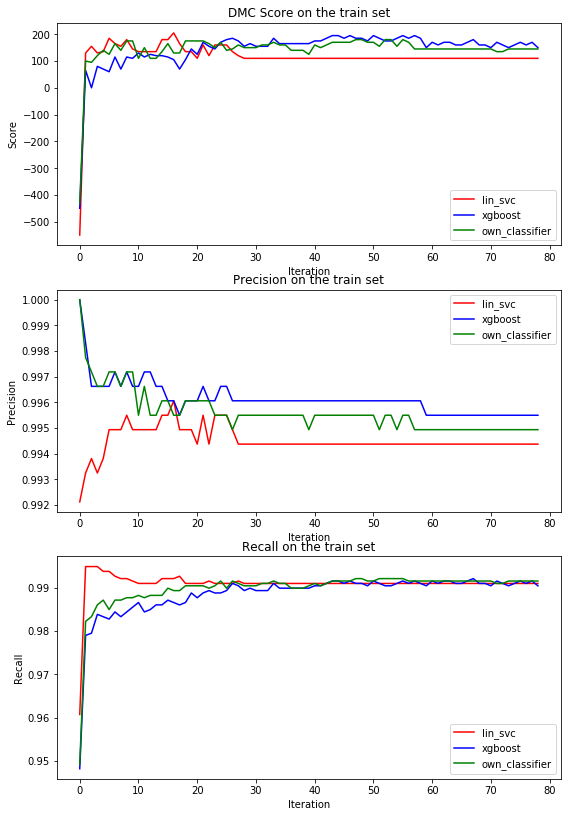

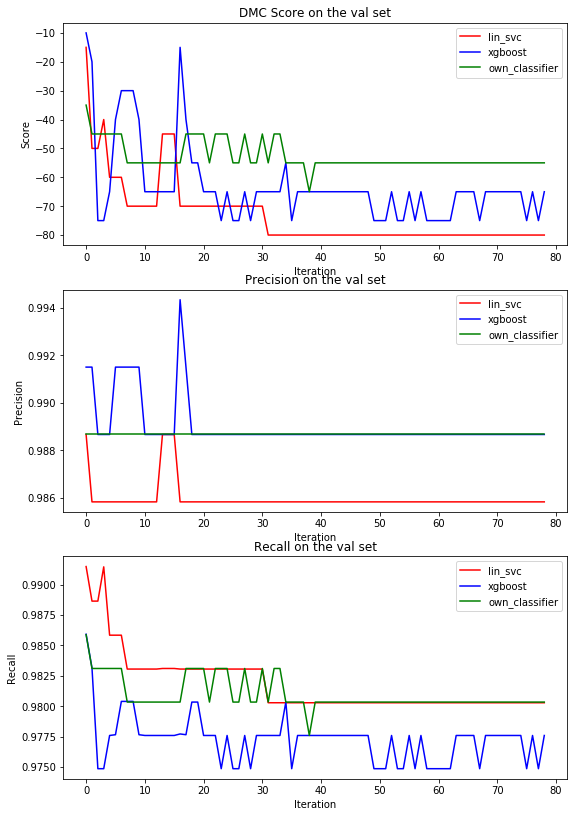

In [18]:
plot_results_ssl(res)

### 7.) pseudo-label the test set and create new classifier based on this
first we predict the original test data labels using the new extended pltrain from above cell and second we use this test data labels to train a new classifier

### 8.) evaluate our new classifier with the original training set

### 9.) combine the pseudo labeled test set with the original train data to train our final classifier

### 10.) predict labels for the test set using our final classifier

### 11.) generate output file neeeded for submission

### 12.) evaluate our new classifier with the validation set
Now at the very end we can also test our final model on a validation split never used before. just for comparison. 

**For the final submission, the following code should will not be run and the full train (incl. this val split) set will be used above**